In [1]:
#James Alfano
import pandas as pd
import datasets
import warnings
import sys
import numpy as np
from Preprocessing import *
from transformers import pipeline
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import transformers
import torch
from huggingface_hub import notebook_login
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc
#! pip install datasets transformers rouge-score nltk

In [2]:
#Run these commands when running for first time
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

## Reading in the Data

In [3]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

Found cached dataset cnn_dailymail (C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
#Read in Training
lst_dics = [dic for dic in dataset["train"]]
train = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
train.head(5)

,text,y,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [6]:
#Read in testing
lst_dics = [dic for dic in dataset["test"]]
test = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
test.head()

,text,y,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,c27cf1b136cc270023de959e7ab24638021bc43f


In [7]:
#Read in Validation
lst_dics = [dic for dic in dataset["validation"]]
validation = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
validation.head()

,text,y,id
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,4157bc4da185971e2742f349d69a037343bc0d95
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,60736693e3b1b32d14337a317190c6606e879a85
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",2e6613d531843515bf5401286cc3e45c4df530d2


In [8]:
print(train.shape)
print(test.shape)
print(validation.shape)


(287113, 3)
(11490, 3)
(13368, 3)


In [9]:
print(train.iloc[0,0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [10]:
print(train.iloc[0,1])

Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


## Preprocessing 

In [11]:
#take a subset of the training data
subset_train = train.iloc[0:15000,0:15000]
subset_test = test.iloc[0:10000,0:10000]
subset_valid = validation.iloc[0:10000,0:10000]


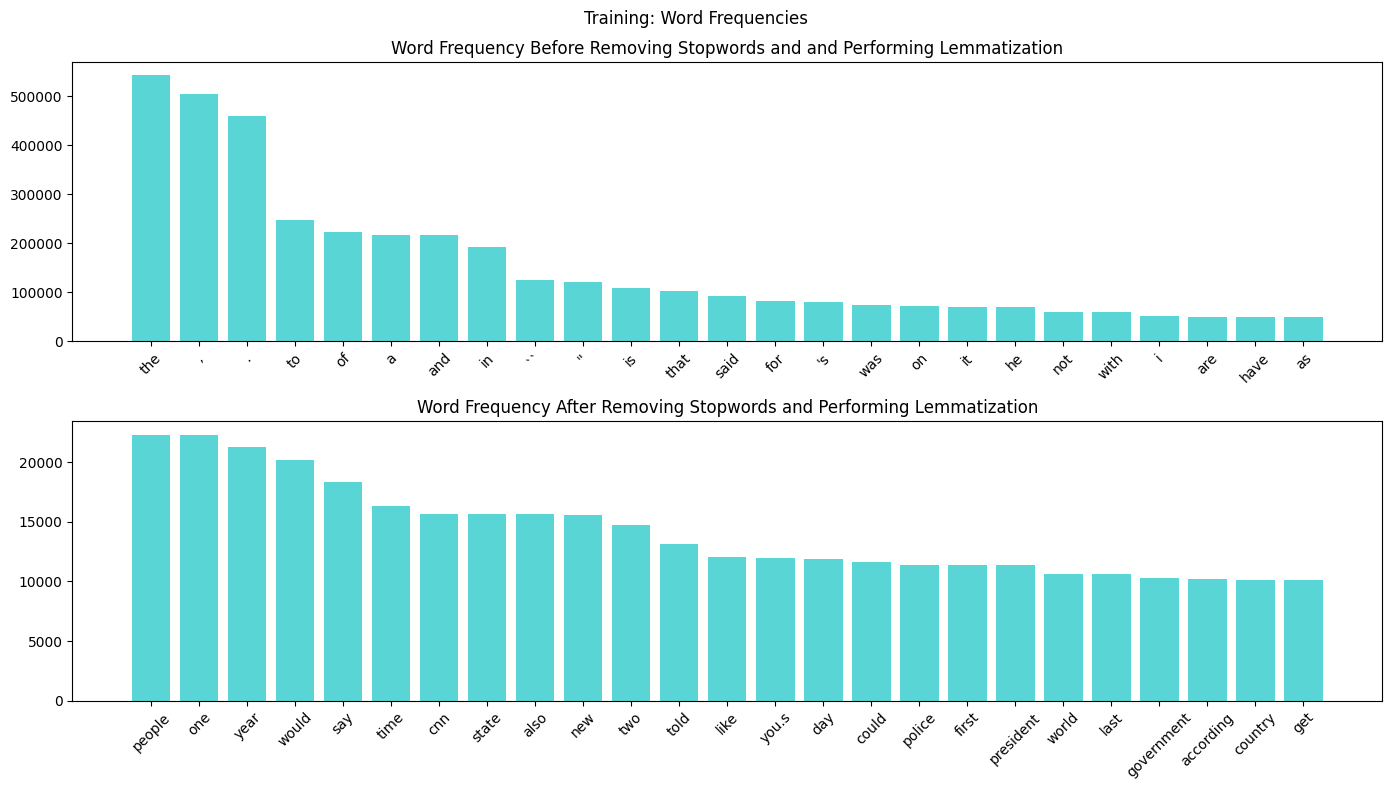

In [12]:
preprocess(subset_train,"Training",1)

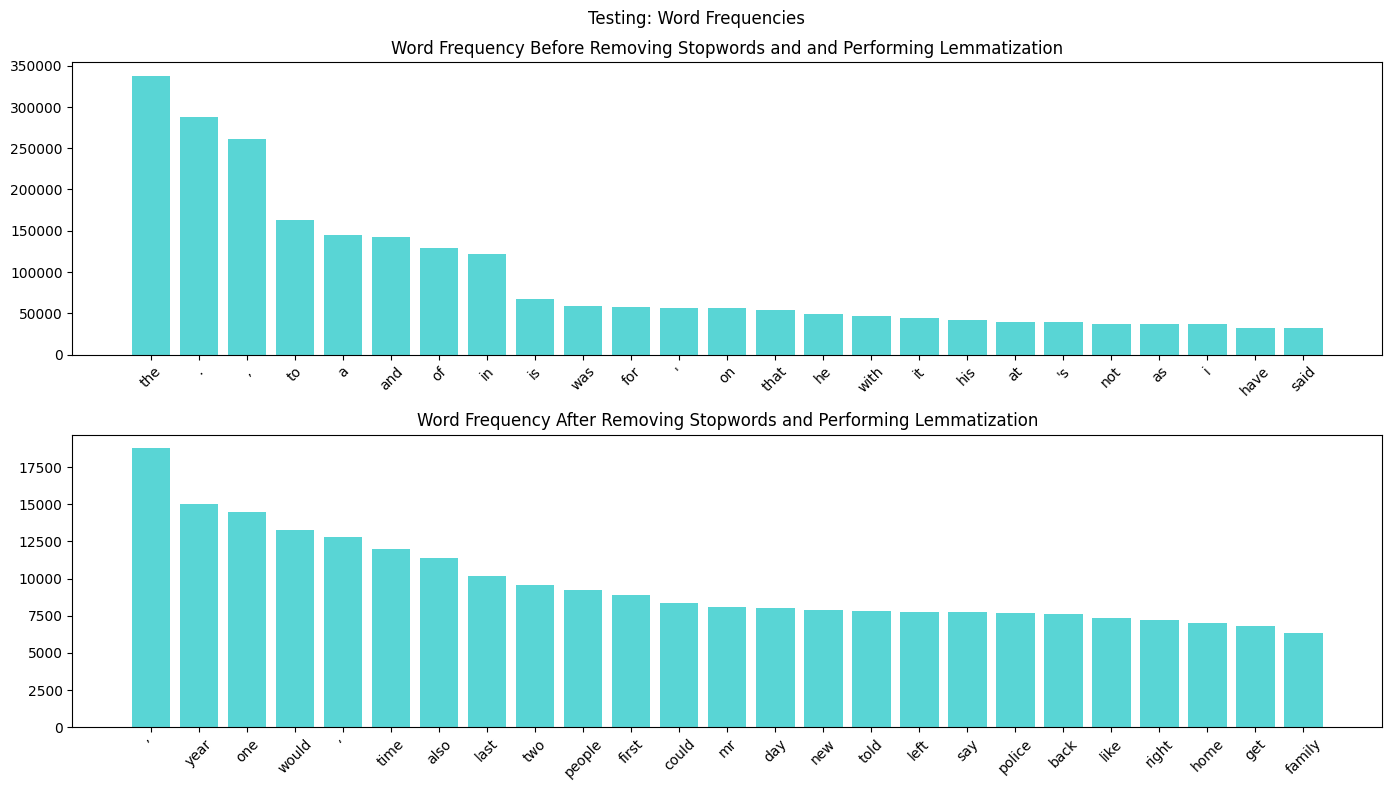

In [13]:
preprocess(subset_test,"Testing",1)

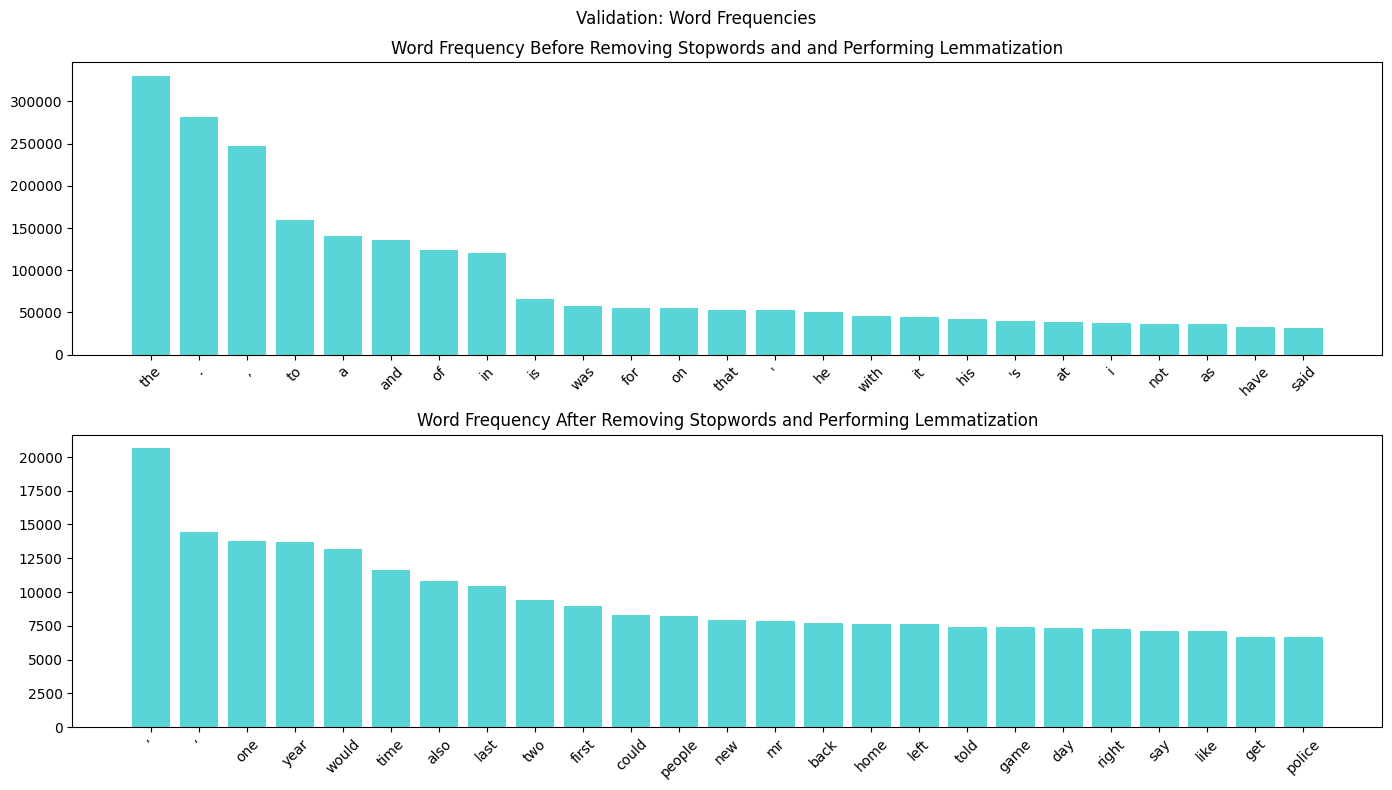

In [14]:
preprocess(subset_valid,"Validation",1)

In [15]:
#Run Function to get the average word count and list of counts for all articles and summaries 
avg_y, lenghts_y = avg_num_words(subset_train["y"])
avg_text, lenghts_text = avg_num_words(subset_train["text"])

The longest summary has 90 words
The longest article has 1295 words


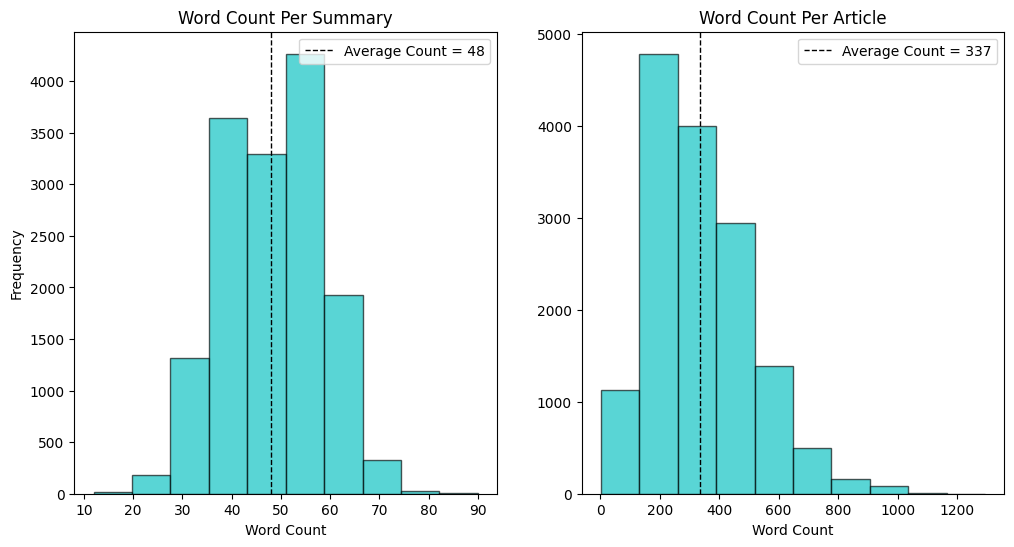

In [16]:
plot_counts(subset_train)

In [19]:
dataset = combine_data(subset_train,subset_test,subset_valid)

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
})

## Building the Model

In [25]:
#warnings.filterwarnings("ignore")
metric = load_metric("rouge")
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

C:\Users\James\AppData\Local\Temp\ipykernel_30820\3519038912.py:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")
c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantia

In [26]:
#Get max lenght for texts and summaries 
max_input_length = max(lenghts_text)
max_target_length = max(lenghts_y)

def prepare_for_model(examples):
    #Model requires summaries of text lead with "summarize: "
    prefix = "summarize: "
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [27]:
tokenized_datasets = dataset.map(prepare_for_model, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [28]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

In [30]:
#The model used below requires significant computing power
#More then my local machine can handle
#This is an attempt to free up processing power

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
 
del train, test, validation
gc.collect()
torch.cuda.empty_cache()

print("Initial GPU Usage")
gpu_usage()                             

torch.cuda.empty_cache()

cuda.select_device(0)
cuda.close()
cuda.select_device(0)

print("GPU Usage after emptying the cache")
gpu_usage()

Using device: cuda
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  7% | 12% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  8% | 14% |


In [31]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [32]:
#batch_size = 4 #4
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-cnn-articles",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    auto_find_batch_size = True, #automated to find a batch size that will fit into memory automatically, avoiding CUDA Out-of-Memory errors
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

In [33]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [34]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [35]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Using cuda_amp half precision backend


## Training

In [36]:
trainer.train()
trainer.save_model()

c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\accelerate\memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 150

  0%|          | 0/1875 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Number of trainable parameters = 60506624


  0%|          | 0/3750 [00:00<?, ?it/s]

Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-500\config.json


{'loss': 3.1161, 'learning_rate': 1.4592000000000002e-05, 'epoch': 0.13}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-1000
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-1000\config.json


{'loss': 2.822, 'learning_rate': 9.269333333333335e-06, 'epoch': 0.27}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-1000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-1000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-3000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-1500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-1500\config.json


{'loss': 2.7708, 'learning_rate': 3.936e-06, 'epoch': 0.4}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-1500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-1500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-3500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-2000
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-2000\config.json


{'loss': 2.7509, 'learning_rate': 0.0, 'epoch': 0.53}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-2000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-2000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-2500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-2500\config.json


{'loss': 2.7496, 'learning_rate': 0.0, 'epoch': 0.67}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-2500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-2500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-3000
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-3000\config.json


{'loss': 2.74, 'learning_rate': 0.0, 'epoch': 0.8}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-3000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-3000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-3500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-3500\config.json


{'loss': 2.7482, 'learning_rate': 0.0, 'epoch': 0.93}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-3500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-3500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-2000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to t5-small-finetuned-cnn-articles
Configuration saved in t5-small-finetuned-cnn-articles\config.json


{'eval_loss': 2.7542479038238525, 'eval_rouge1': 14.3783, 'eval_rouge2': 4.2386, 'eval_rougeL': 11.5176, 'eval_rougeLsum': 13.3315, 'eval_gen_len': 18.9762, 'eval_runtime': 773.0451, 'eval_samples_per_second': 12.936, 'eval_steps_per_second': 1.617, 'epoch': 1.0}
{'train_runtime': 2068.2655, 'train_samples_per_second': 7.252, 'train_steps_per_second': 1.813, 'train_loss': 2.8087823893229165, 'epoch': 1.0}


Model weights saved in t5-small-finetuned-cnn-articles\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\special_tokens_map.json


## Testing

In [ ]:
#Testing
predictions, labels, results  = trainer.predict(tokenized_datasets["test"])
results

## Generating Summaries

In [70]:
#Function to create generate summaries
def summarize_text(text, summary):
    text = "summarize: " + text
    model_name = "t5-small-finetuned-cnn-articles"
    #summarizer = pipeline('text2text-generation', model_name, framework="pt")
    summarizer = pipeline("summarization", model_name, framework="pt")
    summarized_text = summarizer(text, max_length=max_target_length) #max_input_length
    scores = metric.compute(predictions=[summarized_text], references=[summary])
    print("Original Article \n" + text)
    print("\nTarget Summary: \n" + summary)
    print("\n Model Generated Summary: \n" ,summarized_text)
    print("\nRouge1 score: \n", scores["rouge1"].mid)



In [71]:
summarize_text(tokenized_datasets["test"]["article"][0],tokenized_datasets["test"]["highlights"][0])

loading configuration file t5-small-finetuned-cnn-articles\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "transla

Original Article 
summarize: arges well israel united state neither icc member opposed palestinian effort join body palestinian foreign minister riad al-malki speaking wednesday ceremony move toward greater justice palestine formally becomes state party rome statute today world also step closer ending long era impunity injustice according icc news release indeed today brings u closer shared goal justice peace judge kuniko ozaki vice president icc acceding treaty first step palestinian rome statute today enters force state palestine palestine acquires right well responsibility come state party statute substantive commitment taken lightly right group human right watch welcomed development government seeking penalize palestine joining icc immediately end pressure country support universal acceptance court treaty speak welcome membership balkees jarrah international justice counsel group objectionable attempt undermine international justice palestine decision join treaty 100 country around

In [59]:
summarize_text(tokenized_datasets["test"]["article"][1],tokenized_datasets["test"]["highlights"][1])

loading configuration file t5-small-finetuned-cnn-articles\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "transla

Original Article 
summarize: survive according washington state university dog friendly white-and-black bully breed mix named theia receiving care veterinary teaching hospital four day apparent death dog managed stagger nearby farm dirt-covered emaciated found worker took vet help taken moses lake washington resident sara mellado considering everything incredibly gentle loving mellado according wsu news true miracle dog deserves good life theia one year old dog brush death leave unscathed suffered dislocated jaw leg injury caved-in sinus cavity still requires surgery help breathe veterinary hospital good samaritan fund committee awarded money help pay dog treatment mellado set fundraising page help meet remaining cost dog care also created facebook page keep supporter updated donor already surpassed 10,000 target inspired theia tale survival odds fundraising page mellado writes desperate need extensive medical procedure fix nasal damage reset jaw agreed foster finally found loving home

In [60]:
summarize_text(tokenized_datasets["test"]["article"][2],tokenized_datasets["test"]["highlights"][2])

loading configuration file t5-small-finetuned-cnn-articles\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "transla

Original Article 
summarize: detail worked coming week received hero welcome arrived iran sunny friday morning long live zarif crowd chanted car rolled slowly packed street may well read polished unusually one burdened weighty issue jovial internet search mohammad javad zarif jovial yield thousand result certainly gone long way bring iran cold allow rejoin international community fact zarif le well-known six september 2013 zarif tweeted happy rosh hashanah referring jewish new year prompted christine pelosi daughter house minority leader nancy pelosi respond tweet thanks new year would even sweeter would end iran holocaust denial sir perhaps surprise pelosi got response iran never denied zarif tweeted back man perceived denying gone happy new year reference likely former iranian president mahmoud ahmadinejad left office previous month zarif nominated foreign minister ahmadinejad successor hassan rouhami foreign ministry note perhaps defensively due political security condition time dec

In [54]:
#from transformers import pipeline
#model_name = "t5-small-finetuned-cnn-articles"
#summarizer = pipeline('text2text-generation', model_name, framework="pt")
#summarizer = pipeline("summarization", model_name, framework="pt")
#summarized_text = summarizer(document, max_length=max_target_length) #max_input_length


In [31]:
#Evaluate
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, highlights, id. If article, highlights, id are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 2.003919839859009,
 'eval_rouge1': 24.314,
 'eval_rouge2': 11.4643,
 'eval_rougeL': 20.1073,
 'eval_rougeLsum': 22.9302,
 'eval_gen_len': 19.0,
 'eval_runtime': 817.2662,
 'eval_samples_per_second': 12.236,
 'eval_steps_per_second': 1.529,
 'epoch': 1.0}

In [39]:
#Testing
predictions, labels, results  = trainer.predict(tokenized_datasets["test"])
results


The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: highlights, article, id. If highlights, article, id are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]

{'test_loss': 3.023893117904663,
 'test_rouge1': 21.4823,
 'test_rouge2': 8.728,
 'test_rougeL': 17.9859,
 'test_rougeLsum': 17.9982,
 'test_gen_len': 18.9511,
 'test_runtime': 854.847,
 'test_samples_per_second': 11.698,
 'test_steps_per_second': 1.462}